In [1]:
import sys
sys.path.append("..")
import kdd_utilities as util
from importlib import reload
reload(util)

import pandas as pd
from pandas import DataFrame
from pandas import Series
from pandas.tseries.offsets import Week, Day, Hour, Minute
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import validation_curve
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.linear_model import MultiTaskLasso
from sklearn.svm import LinearSVR
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.multioutput import MultiOutputRegressor

import statsmodels.api as sm

import matplotlib.pyplot as plt

### 那些有可能要更改的值，以全局变量的形式写在这里

In [2]:
intersection_id = 'A'
tollgate_id = 2
out_file_name = 'submission_travelTime_' + intersection_id + str(tollgate_id) + '_multi_rf.csv'
print('out_file_name:', out_file_name)

out_file_name: submission_travelTime_A2_multi_rf.csv


### 设置路径

In [3]:
path_dataset = '../../dataSets/'
path_training = path_dataset + 'training/'
path_testing_phase1 = path_dataset + 'testing_phase1/'
path_submission = path_dataset + 'submission/'
path_intermediate_results = path_dataset + 'intermediate_results/'
print('path_training: ', path_training)
print('path_testing_phase1: ', path_testing_phase1)
print('path_submission: ', path_submission)
print('path_intermediate_results: ', path_intermediate_results)

path_training:  ../../dataSets/training/
path_testing_phase1:  ../../dataSets/testing_phase1/
path_submission:  ../../dataSets/submission/
path_intermediate_results:  ../../dataSets/intermediate_results/


### 加载 trajectories(table 5)_training.csv，并提取时间序列

In [4]:
travel_time_training_df = pd.read_csv(path_training + 'trajectories(table 5)_training.csv')
travel_time_training_df.head()

,intersection_id,tollgate_id,vehicle_id,starting_time,travel_seq,travel_time
0,B,3,1065642,2016-07-19 00:14:24,105#2016-07-19 00:14:24#9.56;100#2016-07-19 00...,70.85
1,B,3,1047198,2016-07-19 00:35:56,105#2016-07-19 00:35:56#11.58;100#2016-07-19 0...,148.79
2,B,1,1086390,2016-07-19 00:37:15,105#2016-07-19 00:37:15#5.26;100#2016-07-19 00...,79.76
3,A,2,1071181,2016-07-19 00:37:59,110#2016-07-19 00:37:59#13.74;123#2016-07-19 0...,58.05
4,B,1,1065807,2016-07-19 00:56:21,105#2016-07-19 00:56:21#16.08;100#2016-07-19 0...,137.98


In [180]:
# 提取时间序列
travel_time_training_df.set_index('starting_time', inplace=True)
travel_time_training_df.index = pd.to_datetime(travel_time_training_df.index)
boolean_indexer = (travel_time_training_df['intersection_id'] == intersection_id) & \
    (travel_time_training_df['tollgate_id'] == tollgate_id)
travel_time_training_ts = travel_time_training_df.loc[boolean_indexer, 'travel_time']
# 按时间排序
travel_time_training_ts.sort_index(inplace=True)
# 降采样，20min
travel_time_training_ts_each_20min = travel_time_training_ts.resample('20min').mean().ffill()

# 使用重整索引的方式来补齐最初的几个缺失值
datetime_range_training = pd.date_range('2016-07-19 00:00:00', '2016-10-17 23:40:00', freq='20min')
travel_time_training_ts_each_20min = \
    travel_time_training_ts_each_20min.reindex(datetime_range_training, method='bfill')
travel_time_training_ts_each_20min.name = 'travel_time'
# 重命名 index 为 'time_window_start'
travel_time_training_ts_each_20min.index.name = 'time_window_start'

KeyError: 'starting_time'

In [6]:
# 查看头尾及 size
travel_time_training_ts_each_20min.head()

time_window_start
2016-07-19 00:00:00    58.05
2016-07-19 00:20:00    58.05
2016-07-19 00:40:00    58.05
2016-07-19 01:00:00    58.05
2016-07-19 01:20:00    56.87
Name: travel_time, dtype: float64

In [7]:
travel_time_training_ts_each_20min.tail()

time_window_start
2016-10-17 22:20:00    50.1825
2016-10-17 22:40:00    55.8300
2016-10-17 23:00:00    50.9000
2016-10-17 23:20:00    79.2140
2016-10-17 23:40:00    42.2700
Name: travel_time, dtype: float64

In [8]:
print('size: ', travel_time_training_ts_each_20min.size)

size:  6552


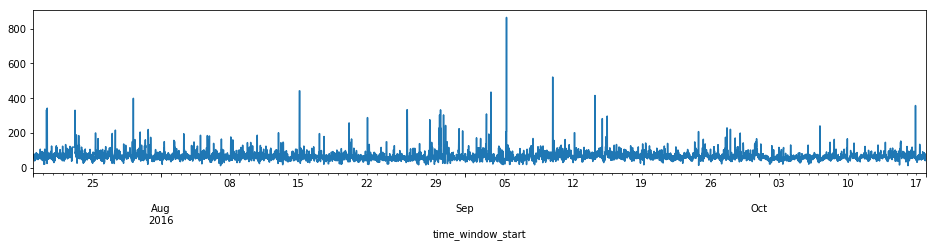

In [9]:
# 观察时序图
travel_time_training_ts_each_20min.plot(figsize=(16, 3))
plt.show()

### 剔除异常值

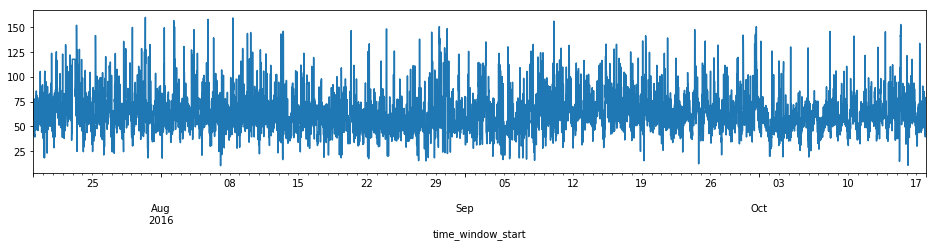

In [10]:
outlier_indexer = \
    (travel_time_training_ts_each_20min - travel_time_training_ts_each_20min.mean()).abs() \
        > 3 * travel_time_training_ts_each_20min.std()
travel_time_training_ts_each_20min[outlier_indexer] = np.nan
travel_time_training_ts_each_20min.fillna(method='ffill', inplace=True)
# 观察时序图
travel_time_training_ts_each_20min.plot(figsize=(16, 3))
plt.show()

### 对比原数据和移动平滑后的数据

In [11]:
# r = travel_time_training_ts_each_20min.rolling(window=3)

# travel_time_training_ts_each_20min['2016-10-10':'2016-10-17'].plot(figsize=(16, 6), color='lightgray')
# r.mean()['2016-10-10':'2016-10-17'].plot(figsize=(16, 6), style='k-')
# plt.show()

### 计算平滑数据的 MAPE

In [12]:
# util.mean_absolute_percentage_error(travel_time_training_ts_each_20min['2016-10-10':'2016-10-17'], r.mean())

### 使用平滑数据覆盖原数据

In [13]:
# travel_time_training_ts_each_20min = r.mean()
# travel_time_training_ts_each_20min.fillna(method='bfill', inplace=True)

### ETS 分解

/home/wp/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


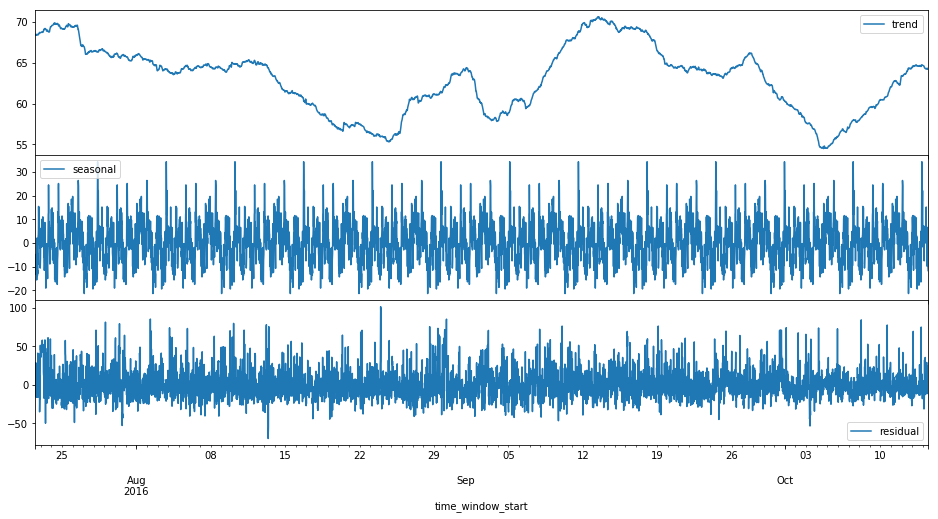

In [11]:
trend_1, seasonal_1, residual_1 = util.ets_decompose(travel_time_training_ts_each_20min, 504)

util.plot_ets(trend_1, seasonal_1, residual_1)

### 保留周期分量

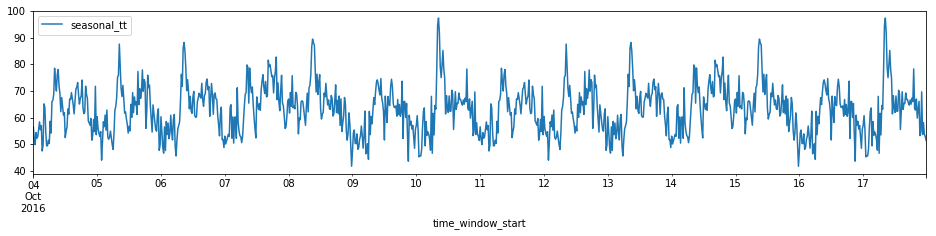

In [12]:
seasonal = seasonal_1 + trend_1.mean() + residual_1.mean()
seasonal.name = 'seasonal_tt'
seasonal['2016-10-04': '2016-10-17'].plot(legend='seasonal',figsize=(16,3))
plt.show()

In [16]:
# seasonally_adjusted_data_1 = trend_1 + residual_1
# seasonally_adjusted_data_1.dropna(inplace=True)
# seasonally_adjusted_data_1.name = 'seasonally_adjusted_data_1'
# seasonally_adjusted_data_1.plot(legend='seasonally_adjusted_data_1',figsize=(16,3))
# plt.show()

### 提取单个周期 [ 2016-10-11: 2016-10-17]

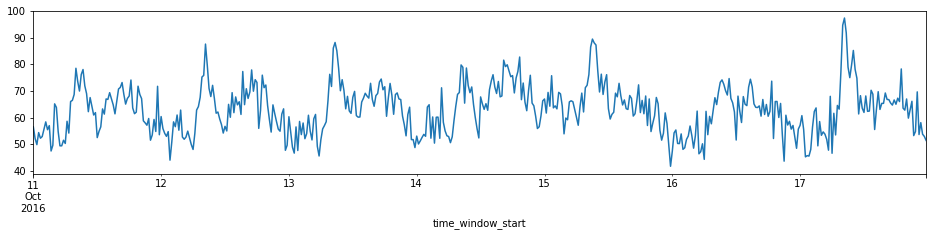

In [13]:
seasonal_one_cycle = seasonal['2016-10-11': '2016-10-17']
seasonal_one_cycle.plot(figsize=(16, 3))
plt.show()

### 平移到 [ 2016-10-18: 2016-10-14]

In [18]:
# seasonal_test1 = seasonal_one_cycle.copy()
# seasonal_test1.index += 1 * Week()
# seasonal_test1.plot(figsize=(16, 3))
# plt.show()

### 构建 multi target 数据集

In [15]:
dt_index = pd.date_range('2016-7-19', '2016-10-17 20:00:00', freq='2H')
tt_training_df = DataFrame(index=dt_index, \
                           columns=['prev_tt_0', 'prev_tt_1', 'prev_tt_2', 'prev_tt_3', 'prev_tt_4', 'prev_tt_5',\
                                    'tt_0', 'tt_1', 'tt_2', 'tt_3', 'tt_4', 'tt_5'])
tt_training_df.index.name = 'time_window_start'
for dt in tt_training_df.index:    
    tt_training_df.loc[dt] = travel_time_training_ts_each_20min.loc[dt: dt + 220 * Minute()].values
tt_training_df = tt_training_df.append(tt_training_df.loc['2016-10-17 20:00:00'])
tt_training_df.head()

,prev_tt_0,prev_tt_1,prev_tt_2,prev_tt_3,prev_tt_4,prev_tt_5,tt_0,tt_1,tt_2,tt_3,tt_4,tt_5
time_window_start,,,,,,,,,,,,
2016-07-19 00:00:00,58.05,58.05,58.05,58.05,56.87,77.74,77.74,42.64,40.1733,40.1733,41.92,39.43
2016-07-19 02:00:00,77.74,42.64,40.1733,40.1733,41.92,39.43,48.13,62.1067,46.115,49.556,54.84,58.0843
2016-07-19 04:00:00,48.13,62.1067,46.115,49.556,54.84,58.0843,46.356,48.588,66.6425,64.681,85.676,58.9689
2016-07-19 06:00:00,46.356,48.588,66.6425,64.681,85.676,58.9689,81.6029,80.2079,63.4485,78.0512,69.0383,69.6571
2016-07-19 08:00:00,81.6029,80.2079,63.4485,78.0512,69.0383,69.6571,78.3115,59.4118,75.4889,72.435,45.9425,47.9757


### 加载 weather (table 7)_training.csv 数据
由于在 task2 中已有详细过程，故此处输出从简

In [16]:
weather_training_df = pd.read_csv(path_training + 'weather (table 7)_training.csv')

# 剔除 wind_direction_ts 中的异常值
wind_direction_ts = weather_training_df['wind_direction']
outlier_index = (wind_direction_ts - wind_direction_ts.mean()).abs() > 3 * wind_direction_ts.std()
weather_training_df.loc[outlier_index, 'wind_direction'] = np.nan
weather_training_df['wind_direction'].fillna(method='ffill', inplace=True)

# 设置 index
weather_training_df['time_window_start'] = 0
for i in weather_training_df.index:
    weather_training_df.loc[i, 'time_window_start'] = \
    pd.to_datetime(str(weather_training_df.loc[i, 'date']) + ' ' + str(weather_training_df.loc[i, 'hour']) + ':00:00')
weather_training_df.set_index('time_window_start', inplace=True)
del weather_training_df['date']
del weather_training_df['hour']

weather_training_df.head()

,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation
time_window_start,,,,,,,
2016-07-01 00:00:00,1000.4,1005.3,225.0,2.1,26.4,94.0,0.0
2016-07-01 03:00:00,1000.5,1005.3,187.0,2.7,29.0,76.0,0.0
2016-07-01 06:00:00,998.9,1003.7,212.0,2.9,31.7,67.0,0.0
2016-07-01 09:00:00,998.7,1003.5,244.0,2.7,31.6,59.0,0.0
2016-07-01 12:00:00,999.7,1004.5,222.0,1.3,29.9,68.0,0.0


In [17]:
# 由于 weather_training_df 的 index 的范围是 [2016-07-01 00:00:00, 2016-10-17 21:00:00]，故重整索引并重采样
weather_training_df = weather_training_df.reindex(tt_training_df.index, method='ffill')
weather_training_df.head()

,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation
time_window_start,,,,,,,
2016-07-19 00:00:00,1000.9,1005.8,219.0,3.3,27.5,81.0,0.0
2016-07-19 02:00:00,1000.9,1005.8,219.0,3.3,27.5,81.0,0.0
2016-07-19 04:00:00,1000.5,1005.3,212.0,3.8,31.7,65.0,0.0
2016-07-19 06:00:00,999.7,1004.5,239.0,1.9,31.8,64.0,0.0
2016-07-19 08:00:00,999.7,1004.5,239.0,1.9,31.8,64.0,0.0


In [18]:
weather_training_df.tail()

,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation
time_window_start,,,,,,,
2016-10-17 14:00:00,1014.3,1019.4,17.0,0.7,19.6,87.0,0.0
2016-10-17 16:00:00,1014.7,1019.8,222.0,0.9,18.9,92.0,0.0
2016-10-17 18:00:00,1014.0,1019.0,341.0,1.5,19.1,92.0,0.0
2016-10-17 20:00:00,1014.0,1019.0,341.0,1.5,19.1,92.0,0.0
2016-10-17 20:00:00,1014.0,1019.0,341.0,1.5,19.1,92.0,0.0


### 添加天气特征

In [19]:
tt_training_df = tt_training_df.join(weather_training_df)
tt_training_df.head()

,prev_tt_0,prev_tt_1,prev_tt_2,prev_tt_3,prev_tt_4,prev_tt_5,tt_0,tt_1,tt_2,tt_3,tt_4,tt_5,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation
time_window_start,,,,,,,,,,,,,,,,,,,
2016-07-19 00:00:00,58.05,58.05,58.05,58.05,56.87,77.74,77.74,42.64,40.1733,40.1733,41.92,39.43,1000.9,1005.8,219.0,3.3,27.5,81.0,0.0
2016-07-19 02:00:00,77.74,42.64,40.1733,40.1733,41.92,39.43,48.13,62.1067,46.115,49.556,54.84,58.0843,1000.9,1005.8,219.0,3.3,27.5,81.0,0.0
2016-07-19 04:00:00,48.13,62.1067,46.115,49.556,54.84,58.0843,46.356,48.588,66.6425,64.681,85.676,58.9689,1000.5,1005.3,212.0,3.8,31.7,65.0,0.0
2016-07-19 06:00:00,46.356,48.588,66.6425,64.681,85.676,58.9689,81.6029,80.2079,63.4485,78.0512,69.0383,69.6571,999.7,1004.5,239.0,1.9,31.8,64.0,0.0
2016-07-19 08:00:00,81.6029,80.2079,63.4485,78.0512,69.0383,69.6571,78.3115,59.4118,75.4889,72.435,45.9425,47.9757,999.7,1004.5,239.0,1.9,31.8,64.0,0.0


### 特征选择（结果可以用于测试集切片）

In [20]:
# 看似很蠢，实则是为了支持任意组合的特征选择，想要剔除某个特征只需要将其注释掉，然后重新运行即可。
selected_features = ['prev_tt_0', 'prev_tt_1', 'prev_tt_2',                  
                     'prev_tt_3', 'prev_tt_4', 'prev_tt_5',
                     'pressure',
                     'sea_pressure',
                     'wind_direction',
                     'wind_speed', 
                     'temperature',
                     'rel_humidity',
                     'precipitation'
                    ]

### 训练集天数选择

In [21]:
trainset_days_num = 77
total_days_num = tt_training_df.index.size // 12
print('total num of days: ', total_days_num)
print('training set: ', trainset_days_num)
print('testing set: ', total_days_num - trainset_days_num)

total num of days:  91
training set:  77
testing set:  14


### Tuning the hyper-parameters of an estimator
A search consists of:

an estimator (regressor or classifier such as sklearn.svm.SVC());----Lasso

a parameter space;----

a method for searching or sampling candidates;----

a cross-validation scheme; and

a score function.----mean_absolute_error


In [22]:
X = tt_training_df.loc[:, selected_features].values
y = tt_training_df.loc[:, 'tt_0': 'tt_5'].values

In [41]:
testset_index_begin = trainset_days_num * 12 # 此处没有 -6

X_train = X[:testset_index_begin] 
y_train = y[:testset_index_begin]
X_test = X[testset_index_begin:]
y_test = y[testset_index_begin:]

# poly = PolynomialFeatures(2, interaction_only=True)
# poly = PolynomialFeatures(1)
# X_train = poly.fit_transform(X_train)
# X_test = poly.transform(X_test)

# # =====尝试 Time Series Split=====

# 以 7 天的数据作为交叉验证集
tscv = TimeSeriesSplit(n_splits=10)
generator = tscv.split(X_train)
print('数据集划分：')
for train, test in tscv.split(X_train):
    print("%s %s" % (np.shape(train), np.shape(test)))

数据集划分：
(84,) (84,)
(168,) (84,)
(252,) (84,)
(336,) (84,)
(420,) (84,)
(504,) (84,)
(588,) (84,)
(672,) (84,)
(756,) (84,)
(840,) (84,)


In [34]:
from sklearn.model_selection import validation_curve, cross_val_score
from xgboost import XGBRegressor

In [68]:
loss = make_scorer(util.mean_absolute_percentage_error, greater_is_better=False)
param_range = list(range(1,5,1))
train_scores, valid_scores = \
    validation_curve(MultiOutputRegressor(XGBRegressor()), X_train, y_train, 'estimator__min_child_weight', \
                     param_range, cv=10, scoring=loss, n_jobs=-1)

In [114]:
def plot_validation_curve(train_scores, valid_scores, xlabel, figsize=(12,9), logspace=False):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)
    plt.figure(figsize=figsize)
    plt.title("Validation Curve")
    plt.xlabel(xlabel)
    plt.ylabel("Score")
    # plt.ylim(-0.20, -0.23)
    lw = 2
    if logspace:
        plt.semilogx(param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw)
    else:
        plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    if logspace:
        plt.semilogx(param_range, valid_scores_mean, label="Cross-validation score", color="navy", lw=lw)
    else:
        plt.plot(param_range, valid_scores_mean, label="Cross-validation score", color="navy", lw=lw)
    plt.fill_between(param_range, valid_scores_mean - valid_scores_std,
                     valid_scores_mean + valid_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    for a,b in zip(param_range, valid_scores_mean): 
        plt.text(a, b, str(b))
    plt.show()

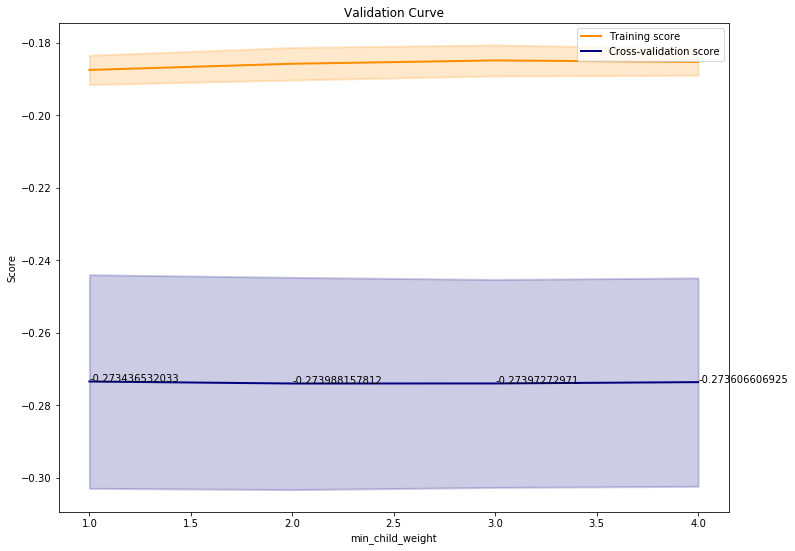

In [69]:
plot_validation_curve(train_scores, valid_scores, 'min_child_weight')

min_child_weight取1

In [90]:
XGBRegressor?

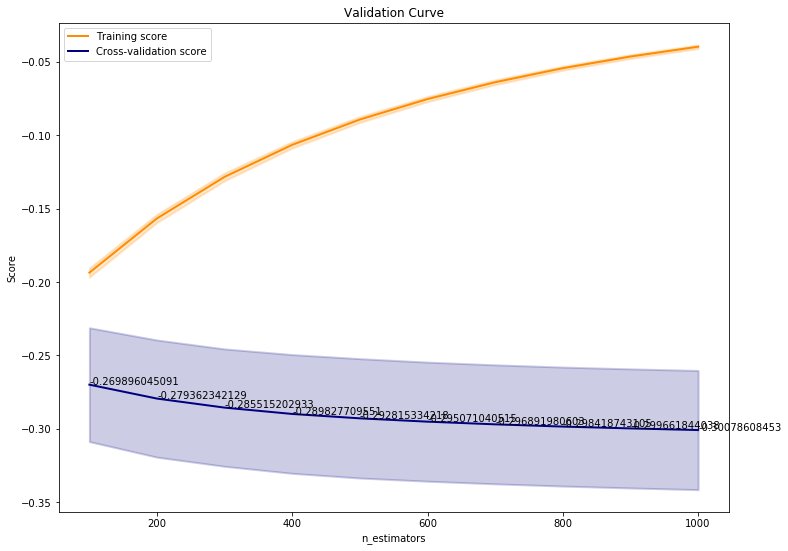

In [91]:
param_range = range(100, 1100, 100)
train_scores, valid_scores = \
    validation_curve(MultiOutputRegressor(XGBRegressor()), X_train, y_train, 'estimator__n_estimators', \
                     param_range, cv=10, scoring=loss, n_jobs=-1)
plot_validation_curve(train_scores, valid_scores, 'n_estimators')

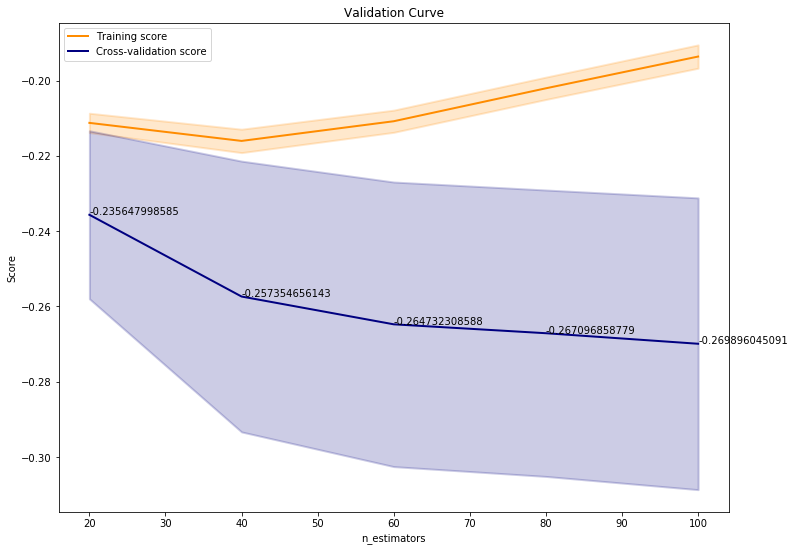

In [92]:
param_range = range(20, 120, 20)
train_scores, valid_scores = \
    validation_curve(MultiOutputRegressor(XGBRegressor()), X_train, y_train, 'estimator__n_estimators', \
                     param_range, cv=10, scoring=loss, n_jobs=-1)
plot_validation_curve(train_scores, valid_scores, 'n_estimators')

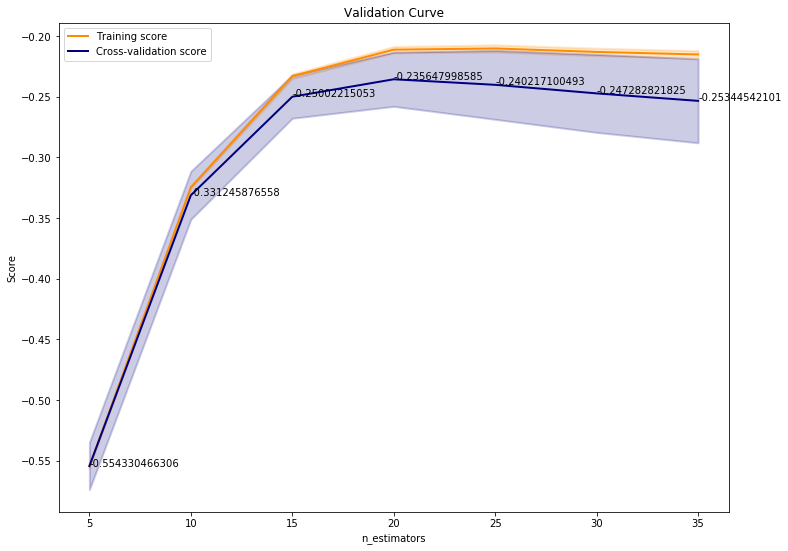

In [94]:
param_range = range(5, 40, 5)
train_scores, valid_scores = \
    validation_curve(MultiOutputRegressor(XGBRegressor()), X_train, y_train, 'estimator__n_estimators', \
                     param_range, cv=10, scoring=loss, n_jobs=-1)
plot_validation_curve(train_scores, valid_scores, 'n_estimators')

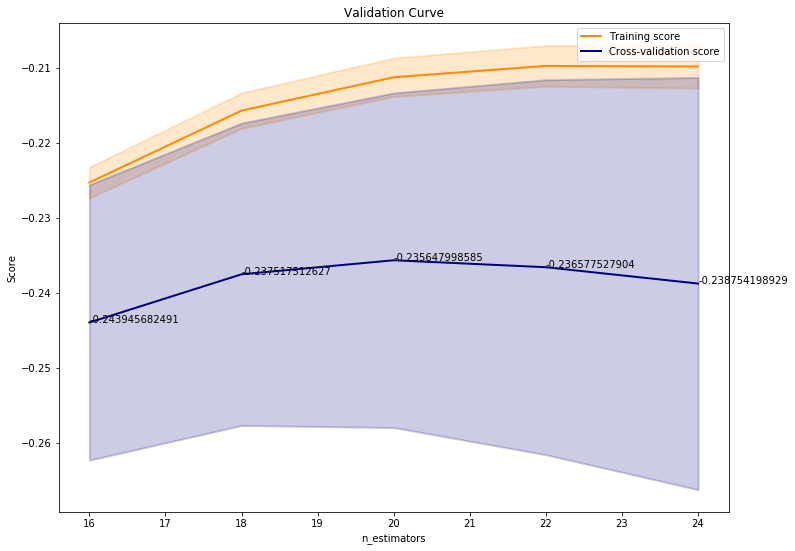

In [95]:
param_range = range(16, 26, 2)
train_scores, valid_scores = \
    validation_curve(MultiOutputRegressor(XGBRegressor()), X_train, y_train, 'estimator__n_estimators', \
                     param_range, cv=10, scoring=loss, n_jobs=-1)
plot_validation_curve(train_scores, valid_scores, 'n_estimators')

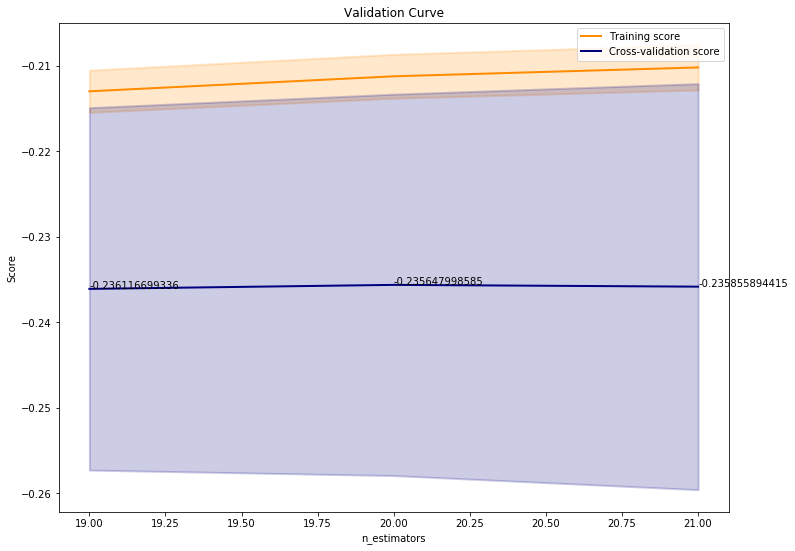

In [96]:
param_range = range(19, 22, 1)
train_scores, valid_scores = \
    validation_curve(MultiOutputRegressor(XGBRegressor()), X_train, y_train, 'estimator__n_estimators', \
                     param_range, cv=10, scoring=loss, n_jobs=-1)
plot_validation_curve(train_scores, valid_scores, 'n_estimators')

n_estimators 取20

### Tune gamma

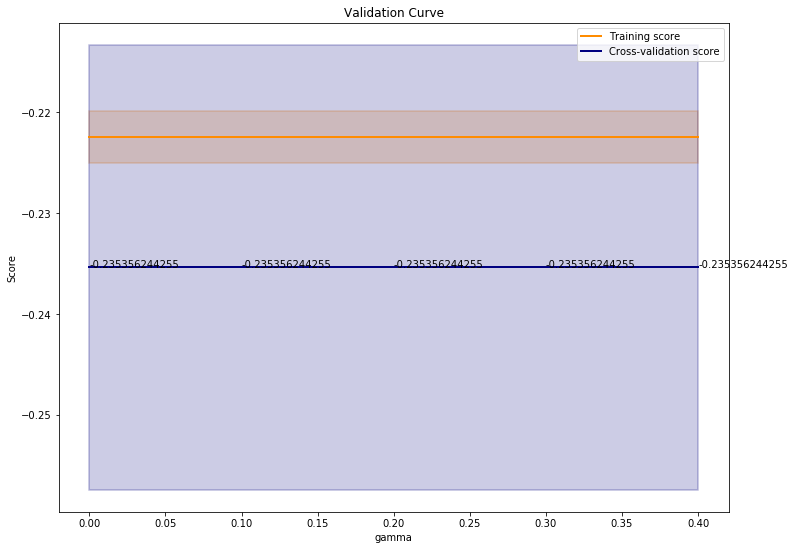

In [98]:
param_range = [i/10.0 for i in range(0,5)]
train_scores, valid_scores = \
    validation_curve(MultiOutputRegressor(XGBRegressor(max_depth=2, n_estimators=20, min_child_weight=1)), \
                     X_train, y_train, 'estimator__gamma', \
                     param_range, cv=10, scoring=loss, n_jobs=-1)
plot_validation_curve(train_scores, valid_scores, 'gamma')

所以gamma取0

### Tune subsample and colsample_bytree

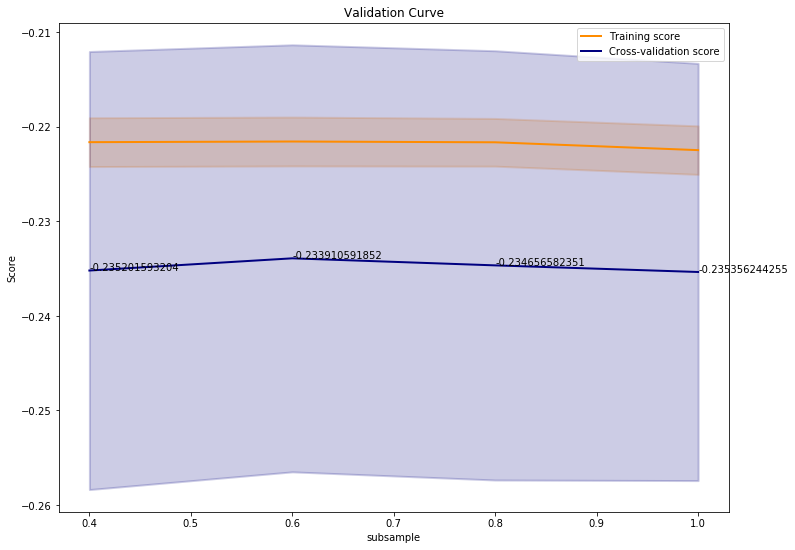

In [99]:
param_range = [0.4, 0.6, 0.8, 1.0]
train_scores, valid_scores = \
    validation_curve(MultiOutputRegressor(XGBRegressor(max_depth=2, n_estimators=20, min_child_weight=1, gamma=0)), \
                     X_train, y_train, 'estimator__subsample', \
                     param_range, cv=10, scoring=loss, n_jobs=-1)
plot_validation_curve(train_scores, valid_scores, 'subsample')

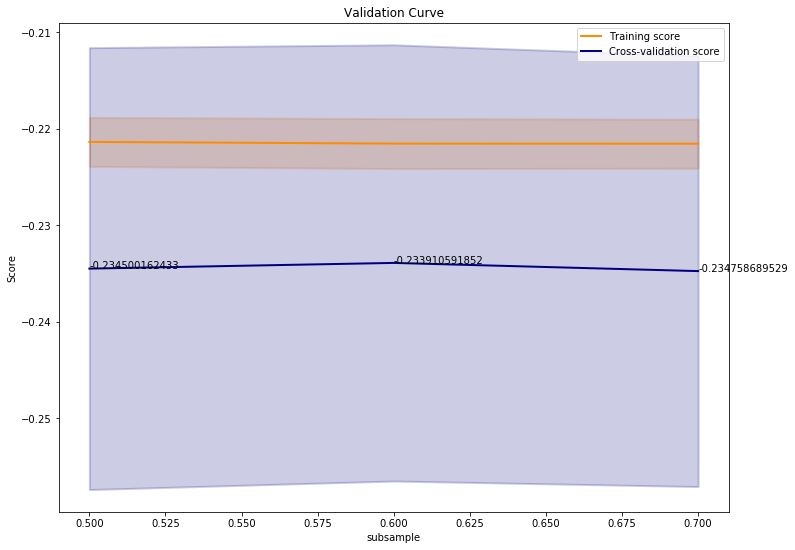

In [101]:
param_range = [0.5, 0.6, 0.7]
train_scores, valid_scores = \
    validation_curve(MultiOutputRegressor(XGBRegressor(max_depth=2, n_estimators=20, min_child_weight=1, gamma=0)), \
                     X_train, y_train, 'estimator__subsample', \
                     param_range, cv=10, scoring=loss, n_jobs=-1)
plot_validation_curve(train_scores, valid_scores, 'subsample')

所以subsample取0.6

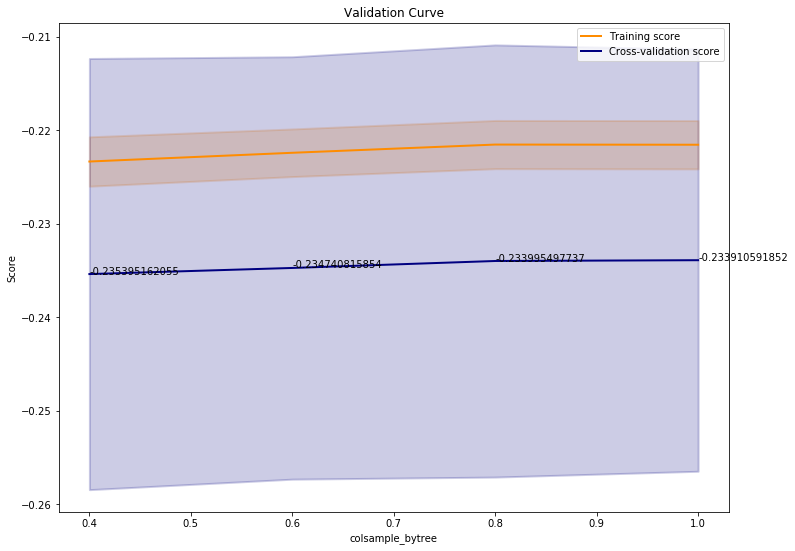

In [100]:
param_range = [0.4, 0.6, 0.8, 1.0]
train_scores, valid_scores = \
    validation_curve(MultiOutputRegressor(XGBRegressor(max_depth=2, n_estimators=20, \
                                                       min_child_weight=1, gamma=0, subsample=0.6)), \
                     X_train, y_train, 'estimator__colsample_bytree', \
                     param_range, cv=10, scoring=loss, n_jobs=-1)
plot_validation_curve(train_scores, valid_scores, 'colsample_bytree')

colsample_bytree取1

### Tuning Regularization Parameters

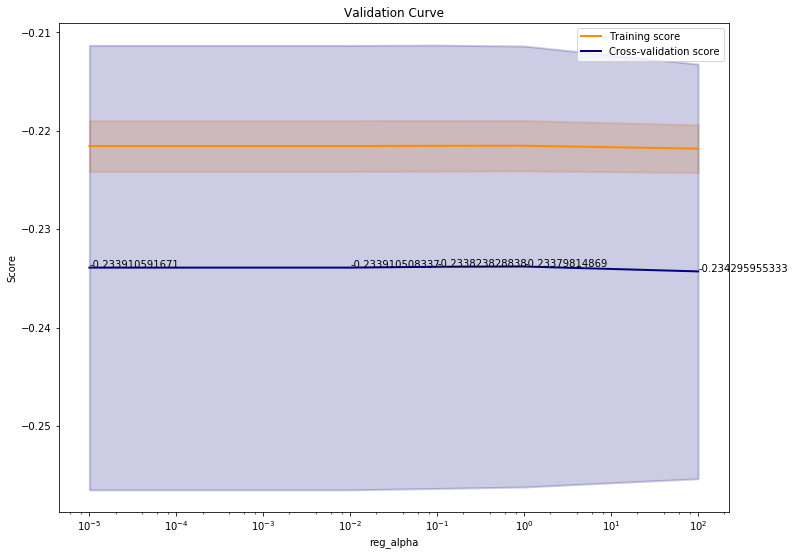

In [115]:
param_range = [1e-5, 1e-2, 0.1, 1, 100]
train_scores, valid_scores = \
    validation_curve(MultiOutputRegressor(XGBRegressor(max_depth=2, n_estimators=20, \
                                                       min_child_weight=1, gamma=0, subsample=0.6, colsample_bytree=1)), \
                     X_train, y_train, 'estimator__reg_alpha', \
                     param_range, cv=10, scoring=loss, n_jobs=-1)
plot_validation_curve(train_scores, valid_scores, 'reg_alpha', logspace=True)

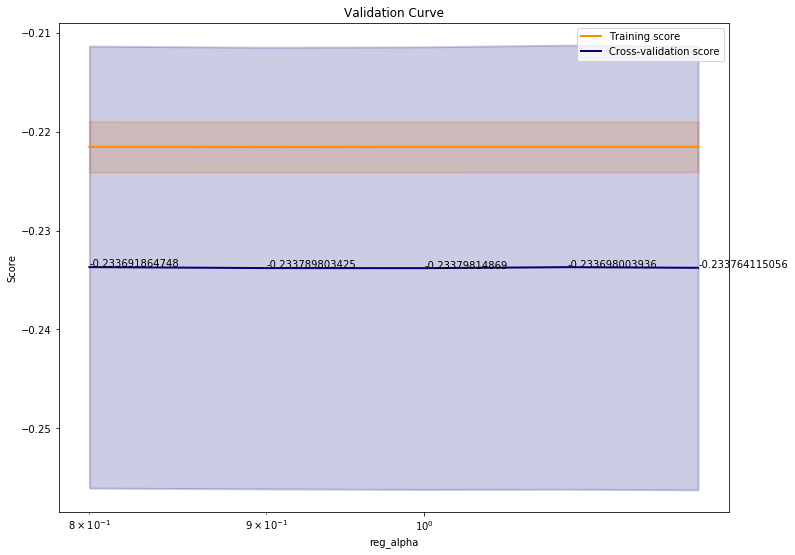

In [116]:
param_range = [0.8, 0.9, 1.0, 1.1, 1.2]
train_scores, valid_scores = \
    validation_curve(MultiOutputRegressor(XGBRegressor(max_depth=2, n_estimators=20, \
                                                       min_child_weight=1, gamma=0, subsample=0.6, colsample_bytree=1)), \
                     X_train, y_train, 'estimator__reg_alpha', \
                     param_range, cv=10, scoring=loss, n_jobs=-1)
plot_validation_curve(train_scores, valid_scores, 'reg_alpha')

In [122]:
np.logspace(-1, 0, 10)

array([ 0.1       ,  0.12915497,  0.16681005,  0.21544347,  0.27825594,
        0.35938137,  0.46415888,  0.59948425,  0.77426368,  1.        ])

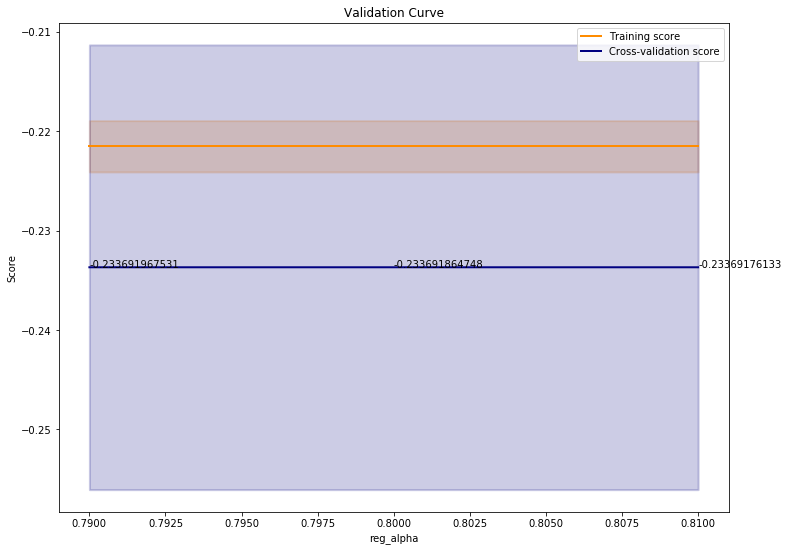

In [127]:
param_range = [0.79, 0.8, 0.81]
train_scores, valid_scores = \
    validation_curve(MultiOutputRegressor(XGBRegressor(max_depth=2, n_estimators=20, \
                                                       min_child_weight=1, gamma=0, subsample=0.6, colsample_bytree=1)), \
                     X_train, y_train, 'estimator__reg_alpha', \
                     param_range, cv=10, scoring=loss, n_jobs=-1)
plot_validation_curve(train_scores, valid_scores, 'reg_alpha')

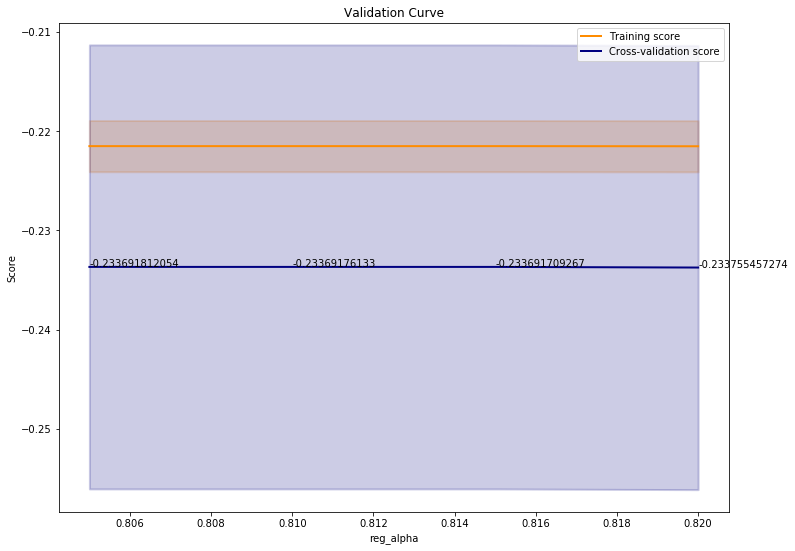

In [129]:
param_range = [0.805, 0.81, 0.815, 0.82]
train_scores, valid_scores = \
    validation_curve(MultiOutputRegressor(XGBRegressor(max_depth=2, n_estimators=20, \
                                                       min_child_weight=1, gamma=0, subsample=0.6, colsample_bytree=1)), \
                     X_train, y_train, 'estimator__reg_alpha', \
                     param_range, cv=10, scoring=loss, n_jobs=-1)
plot_validation_curve(train_scores, valid_scores, 'reg_alpha')

reg_alpha取0.815

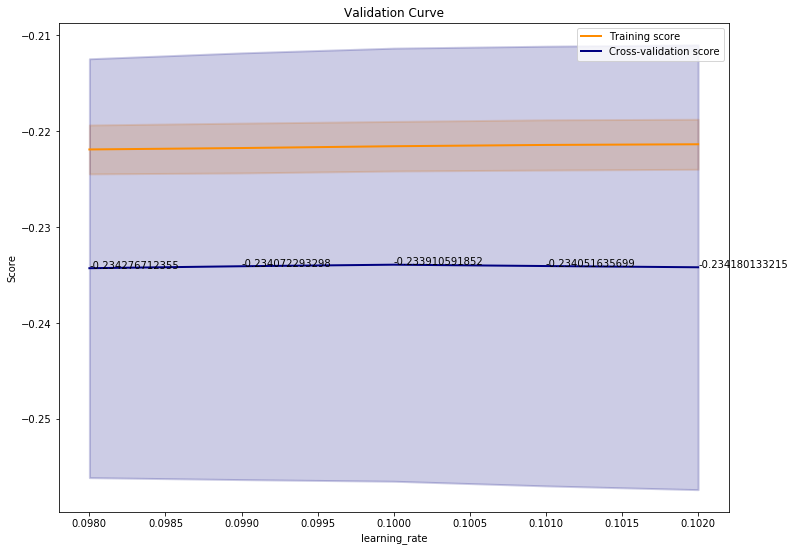

In [160]:
param_range = [0.098, 0.099, 0.1, 0.101, 0.102]
train_scores, valid_scores = \
    validation_curve(MultiOutputRegressor(XGBRegressor(max_depth=2, n_estimators=20, \
                                                       min_child_weight=1, gamma=0, subsample=0.6, colsample_bytree=1)), \
                     X_train, y_train, 'estimator__learning_rate', \
                     param_range, cv=10, scoring=loss, n_jobs=-1)
plot_validation_curve(train_scores, valid_scores, 'learning_rate')

In [425]:
loss = make_scorer(util.mean_absolute_percentage_error, greater_is_better=False)
# param_grid = {'alpha': alphas, 'normalize': [True, False]}
n_alpha = 20
alphas = np.logspace(-10, 10, n_alpha)
# param_grid = {'alpha': alphas}
# reg = GridSearchCV(Ridge(normalize=True), param_grid, cv=generator, scoring=loss, n_jobs=-1)
# reg = GridSearchCV(Ridge(normalize=True), param_grid, cv=generator, scoring=loss, n_jobs=-1)
# reg = RandomForestRegressor(n_jobs=-1) 
# reg = ExtraTreesRegressor(n_estimators=70, n_jobs=-1) 
# reg = MultiTaskLassoCV(normalize=True, cv=10, n_jobs=-1)
# reg = MultiOutputRegressor(BaggingRegressor(LinearRegression(normalize=True, n_jobs=-1), \
#                        n_jobs=-1, bootstrap_features=True))
# reg = RidgeCV(alphas=alphas, normalize=True, scoring=loss, store_cv_values=True)
reg = LinearRegression(normalize=True, n_jobs=-1)
# reg = LinearSVR()
# n_estimators = [10, 20]
# param_grid = {'n_estimators': n_estimators}
# reg = GridSearchCV(RandomForestRegressor(criterion='mae', n_jobs=-1), \
#                    param_grid, cv=generator, scoring=loss, n_jobs=-1)

In [27]:
reg.fit(X_train, y_train)
# print(reg.alpha_)

MultiOutputRegressor(estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
           n_jobs=1)

In [427]:
# train_scores, valid_scores = validation_curve(Ridge(normalize=True), X, y, "alpha", alphas, \
#                                              cv=10, scoring=loss, n_jobs=-1)

In [428]:
# train_scores = train_scores.mean(axis=1)
# valid_scores = valid_scores.mean(axis=1)

In [429]:
# plt.figure(figsize=(16,4))
# plt.plot(alphas, train_scores, 'lightgray')
# plt.plot(alphas, valid_scores, 'k')
# plt.show()

In [430]:
# print('best_score_: ', reg.best_score_)
# print('MAPE: ', -reg.best_score_)
# print('best_params_: ', reg.best_params_)
# print('best_index_: ', reg.best_index_)
# print('best_estimator_: ', reg.best_estimator_)

### 训练集上的拟合情况

In [161]:
reg = MultiOutputRegressor(XGBRegressor(max_depth=2, learning_rate=0.1,n_estimators=20, min_child_weight=1, gamma=0, \
                                        subsample=0.6, colsample_bytree=1, reg_alpha=0.815))
reg.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=20, nthread=-1,
       objective='reg:linear', reg_alpha=0.815, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.6),
           n_jobs=1)

In [162]:
y_train_pred = reg.predict(X_train)
print('MAPE:', util.mean_absolute_percentage_error(y_train.ravel(), y_train_pred.ravel()))

MAPE: 0.22203737931094972


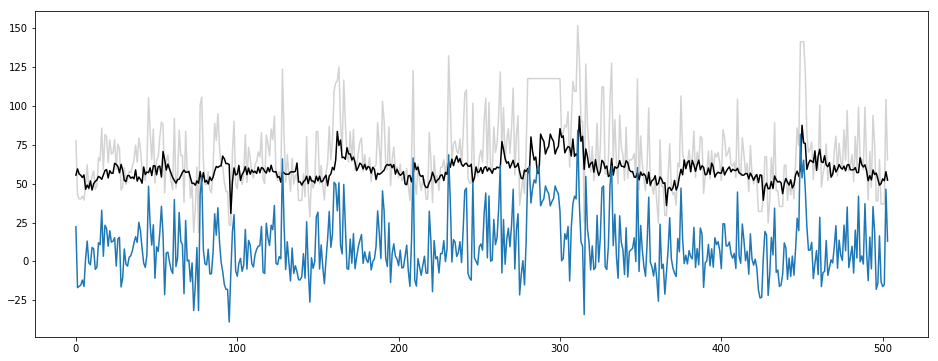

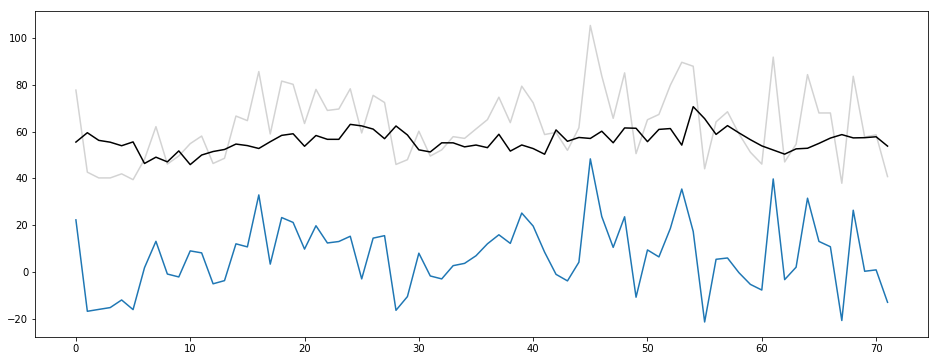

In [163]:
fig = plt.figure(figsize=(16, 6))
plt.plot(y_train.ravel()[:504], 'lightgray')
plt.plot(y_train_pred.ravel()[:504], 'k')
plt.plot(y_train.ravel()[:504] - y_train_pred.ravel()[:504])
plt.show()
fig = plt.figure(figsize=(16, 6))
plt.plot(y_train.ravel()[:72], 'lightgray')
plt.plot(y_train_pred.ravel()[:72], 'k')
plt.plot(y_train.ravel()[:72] - y_train_pred.ravel()[:72])
plt.show()

### 测试集上的拟合情况

In [164]:
y_test_pred = reg.predict(X_test)
print('MAPE:', util.mean_absolute_percentage_error(y_test.ravel(), y_test_pred.ravel()))

MAPE: 0.1952494250059209


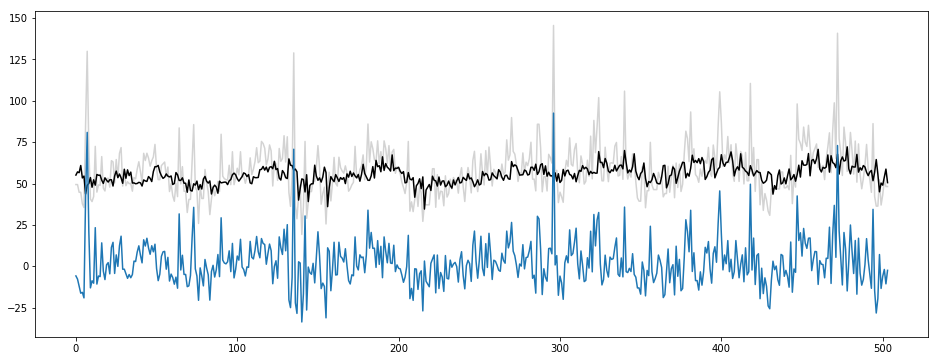

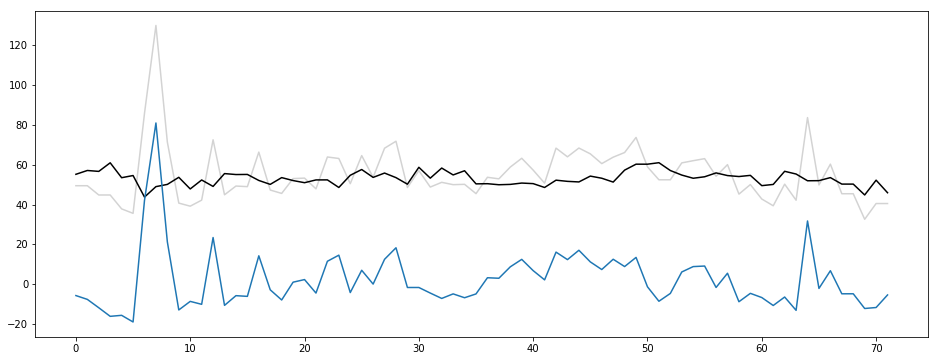

In [150]:
fig = plt.figure(figsize=(16, 6))
plt.plot(y_test.ravel()[:504], 'lightgray')
plt.plot(y_test_pred.ravel()[:504], 'k')
plt.plot(y_test.ravel()[:504] - y_test_pred.ravel()[:504])
plt.show()
fig = plt.figure(figsize=(16, 6))
plt.plot(y_test.ravel()[:72], 'lightgray')
plt.plot(y_test_pred.ravel()[:72], 'k')
plt.plot(y_test.ravel()[:72] - y_test_pred.ravel()[:72])
plt.show()

### Plotting Learning Curves

In [165]:
reload(util)
train_sizes=np.linspace(.1, 1.0, 14)
loss = make_scorer(util.mean_absolute_percentage_error, greater_is_better=False)
train_sizes_abs, train_scores, test_scores = \
    learning_curve(reg, X_train, y_train, cv=5, n_jobs=-1, train_sizes=train_sizes, scoring=loss)

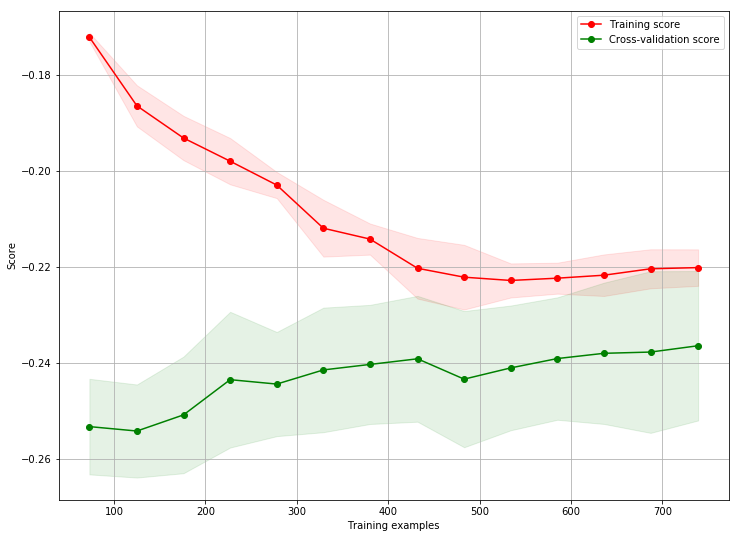

In [166]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(12,9))
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()
plt.fill_between(train_sizes_abs, train_scores_mean - train_scores_std, \
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes_abs, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes_abs, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes_abs, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.legend(loc="best")
plt.show()

### 手动绘制 Learning Curves

In [437]:
def custom_learning_curve(estimator, X, y):
    error_train_matrix = []
    error_cv_matrix = []
    train_sizes_abs = []
    for i in range(1, 12):
        end = i * 7 * 12 # 不被包含
        train_sizes_abs.append(end)
        X_tmp = X[:end, :]
        y_tmp = y[:end, :]
        
        tscv = TimeSeriesSplit(n_splits=6)
        generator = tscv.split(X_tmp)
        
        error_train_list = []
        error_cv_list = []
        for index_train, index_cv in generator:
            X_train = X_tmp[index_train]
            y_train = y_tmp[index_train]
            estimator.fit(X_train, y_train)
            y_train_pred = estimator.predict(X_train)
            error_train = util.mean_absolute_percentage_error(y_train, y_train_pred)
            error_train_list.append(error_train)
            
            X_cv = X[index_cv]
            y_cv = y[index_cv]
            X_cv_pred = estimator.predict(X_cv)
            error_cv = util.mean_absolute_percentage_error(y_cv, X_cv_pred)
            error_cv_list.append(error_cv)
        error_train_matrix.append(error_train_list)
        error_cv_matrix.append(error_cv_list)
    return train_sizes_abs, error_train_matrix, error_cv_matrix

In [438]:
train_sizes_abs, error_train_matrix, error_cv_matrix = \
    custom_learning_curve(reg, X_train, y_train)

In [439]:
# train_sizes_abs, error_train_matrix, error_cv_matrix = \
#     custom_learning_curve(reg.best_estimator_, X_train, y_train)

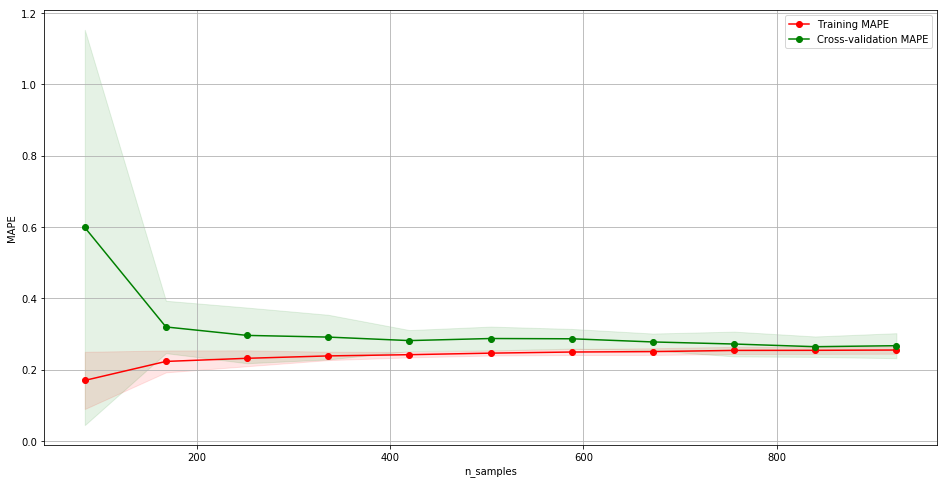

In [440]:
error_train_mean = np.mean(error_train_matrix, axis=1)
error_train_std = np.std(error_train_matrix, axis=1)
error_cv_mean = np.mean(error_cv_matrix, axis=1)
error_cv_std = np.std(error_cv_matrix, axis=1)

plt.figure(figsize=(16, 8))
plt.xlabel("n_samples")
plt.ylabel("MAPE")
plt.grid()
plt.fill_between(train_sizes_abs, error_train_mean - error_train_std, \
                 error_train_mean + error_train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes_abs, error_cv_mean - error_cv_std, error_cv_mean + error_cv_std, alpha=0.1, color="g")
plt.plot(train_sizes_abs, error_train_mean, 'o-', color="r", label="Training MAPE")
plt.plot(train_sizes_abs, error_cv_mean, 'o-', color="g", label="Cross-validation MAPE")
plt.legend(loc="best")
plt.show()

### 加载 trajectories(table 5)_test1.csv 并提取时间序列

In [167]:
# 加载数据
travel_time_test1_df = pd.read_csv(path_testing_phase1 + 'trajectories(table 5)_test1.csv')
travel_time_test1_df.head()

,intersection_id,tollgate_id,vehicle_id,starting_time,travel_seq,travel_time
0,A,2,1026631,2016-10-18 06:00:14,110#2016-10-18 06:00:14#7.65;123#2016-10-18 06...,27.54
1,C,3,1017312,2016-10-18 06:00:28,115#2016-10-18 06:00:28#9.35;102#2016-10-18 06...,139.53
2,A,2,1044671,2016-10-18 06:03:07,110#2016-10-18 06:03:07#7.22;123#2016-10-18 06...,26.01
3,A,3,1000017,2016-10-18 06:04:37,110#2016-10-18 06:04:37#7.39;123#2016-10-18 06...,78.40
4,A,2,1002850,2016-10-18 06:10:17,110#2016-10-18 06:10:17#14.33;123#2016-10-18 0...,71.00


In [168]:
# 提取时间序列
travel_time_test1_df.set_index('starting_time', inplace=True)
boolean_indexer = (travel_time_test1_df['intersection_id'] == intersection_id) & \
    (travel_time_test1_df['tollgate_id'] == tollgate_id)
travel_time_test1_ts = travel_time_test1_df.loc[boolean_indexer, 'travel_time']
travel_time_test1_ts.index = pd.to_datetime(travel_time_test1_ts.index)
# 按时间排序
travel_time_test1_ts.sort_index(inplace=True)
# 降采样，20min
travel_time_test1_ts_each_20min = travel_time_test1_ts.resample('20min').mean().ffill()
# 切片出所需的部分
boolean_indexer_0810 = (6 <= travel_time_test1_ts_each_20min.index.hour)\
    & (travel_time_test1_ts_each_20min.index.hour < 8)
boolean_indexer_1719 = (15 <= travel_time_test1_ts_each_20min.index.hour)\
    & (travel_time_test1_ts_each_20min.index.hour < 17)
boolean_indexer_0810_1719 = boolean_indexer_0810 | boolean_indexer_1719
travel_time_test1_ts_each_20min = travel_time_test1_ts_each_20min[boolean_indexer_0810_1719]
# 重命名 index 为 'time_window_start'
travel_time_test1_ts_each_20min.index.name = 'time_window_start'

In [169]:
# 查看头尾及 size
travel_time_test1_ts_each_20min.head(6)

time_window_start
2016-10-18 06:00:00    41.097143
2016-10-18 06:20:00    43.681667
2016-10-18 06:40:00    68.024286
2016-10-18 07:00:00    52.608333
2016-10-18 07:20:00    56.165556
2016-10-18 07:40:00    63.598571
Name: travel_time, dtype: float64

In [170]:
travel_time_test1_ts_each_20min.tail(6)

time_window_start
2016-10-24 15:00:00    95.172222
2016-10-24 15:20:00    51.873636
2016-10-24 15:40:00    44.688333
2016-10-24 16:00:00    87.304667
2016-10-24 16:20:00    67.715000
2016-10-24 16:40:00    58.797778
Name: travel_time, dtype: float64

In [171]:
print('shape: ', travel_time_test1_ts_each_20min.shape)

shape:  (84,)


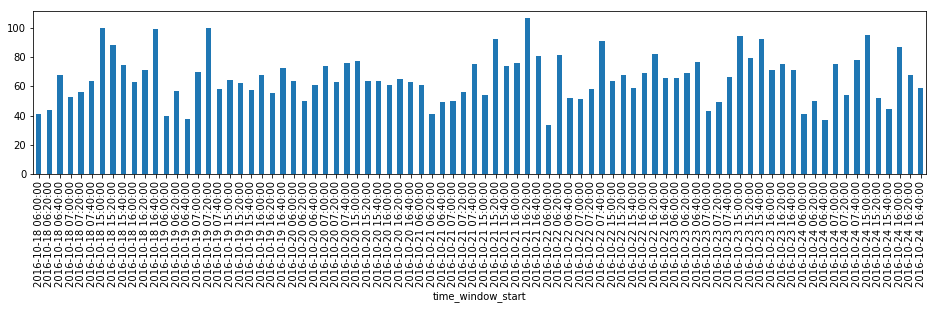

In [172]:
# 观察时序图
travel_time_test1_ts_each_20min.plot(figsize=(16, 3), kind='bar')
plt.show()

### 剔除异常值

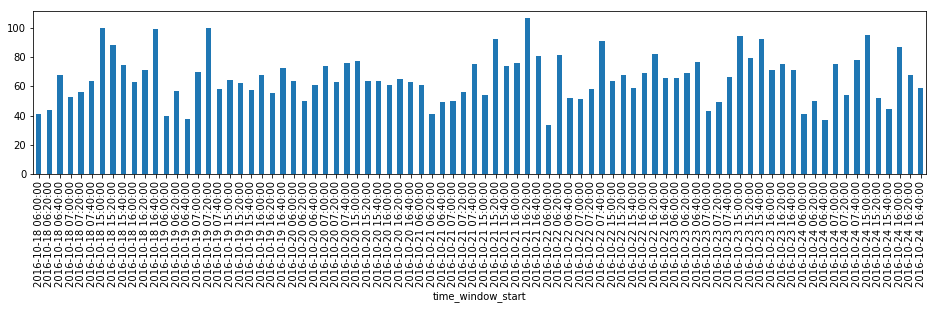

In [173]:
outlier_indexer = \
    (travel_time_test1_ts_each_20min - travel_time_test1_ts_each_20min.mean()).abs() \
        > 3 * travel_time_test1_ts_each_20min.std()
travel_time_test1_ts_each_20min[outlier_indexer] = np.nan
travel_time_test1_ts_each_20min.fillna(method='ffill', inplace=True)
# 观察时序图
travel_time_test1_ts_each_20min.plot(figsize=(16, 3), kind='bar')
plt.show()

### 构建 multi target 数据集

In [174]:
tt_test1_df = DataFrame(index=travel_time_test1_ts_each_20min.index[::6], \
                           columns=['prev_tt_0', 'prev_tt_1', 'prev_tt_2', 'prev_tt_3', 'prev_tt_4', 'prev_tt_5'])
tt_test1_df.index.name = 'time_window_start'
for dt in tt_test1_df.index:    
    tt_test1_df.loc[dt] = travel_time_test1_ts_each_20min.loc[dt: dt + 100 * Minute()].values
tt_test1_df

,prev_tt_0,prev_tt_1,prev_tt_2,prev_tt_3,prev_tt_4,prev_tt_5
time_window_start,,,,,,
2016-10-18 06:00:00,41.0971,43.6817,68.0243,52.6083,56.1656,63.5986
2016-10-18 15:00:00,99.9607,88.3606,74.886,63.3027,71.362,99.2609
2016-10-19 06:00:00,40.01,57.0073,37.412,69.584,100.114,58.2921
2016-10-19 15:00:00,64.4629,62.3078,57.33,67.584,55.19,72.4764
2016-10-20 06:00:00,63.584,49.7933,60.885,74.0737,62.9886,75.7936
2016-10-20 15:00:00,77.1618,63.9789,63.675,61.178,65.197,63.0462
2016-10-21 06:00:00,60.9329,40.73,48.952,49.8733,55.8511,75.138
2016-10-21 15:00:00,53.9143,92.3342,74.0746,76.286,106.663,80.6664
2016-10-22 06:00:00,33.6762,81.5667,52.29,51.072,58.39,90.938


### 加载 weather (table 7)_test1.csv 数据
由于在 task2 中已有详细过程，故此处输出从简

In [175]:
weather_test1_df = pd.read_csv(path_testing_phase1 + 'weather (table 7)_test1.csv')

# 设置 index
weather_test1_df['time_window_start'] = 0
for i in weather_test1_df.index:
    weather_test1_df.loc[i, 'time_window_start'] = \
    pd.to_datetime(str(weather_test1_df.loc[i, 'date']) + ' ' + str(weather_test1_df.loc[i, 'hour']) + ':00:00')
weather_test1_df.set_index('time_window_start', inplace=True)
del weather_test1_df['date']
del weather_test1_df['hour']

# # 由于 weather_training_df 的 index 的范围是 [2016-10-18 00:00:00, 2016-10-24 21:00:00]，故重整索引并重采样
weather_test1_df = weather_test1_df.reindex(tt_test1_df.index, method='ffill')

weather_test1_df.head(6)
weather_test1_df.tail(6)

,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation
time_window_start,,,,,,,
2016-10-22 06:00:00,1000.2,1005.1,86.0,2.9,22.6,96.0,0.1
2016-10-22 15:00:00,1004.0,1009.0,352.0,4.8,20.7,96.0,1.6
2016-10-23 06:00:00,1009.1,1014.1,13.0,3.2,20.6,84.0,0.0
2016-10-23 15:00:00,1011.4,1016.4,326.0,1.1,19.7,92.0,0.0
2016-10-24 06:00:00,1007.7,1012.7,175.0,1.4,24.5,68.0,0.0
2016-10-24 15:00:00,1008.0,1013.0,210.0,1.4,21.0,91.0,0.0


### 添加天气特征

In [176]:
tt_test1_df = tt_test1_df.join(weather_test1_df)
tt_test1_df.head()

,prev_tt_0,prev_tt_1,prev_tt_2,prev_tt_3,prev_tt_4,prev_tt_5,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation
time_window_start,,,,,,,,,,,,,
2016-10-18 06:00:00,41.0971,43.6817,68.0243,52.6083,56.1656,63.5986,1012.5,1017.5,128.0,1.6,23.4,73.0,0.0
2016-10-18 15:00:00,99.9607,88.3606,74.886,63.3027,71.362,99.2609,1013.7,1018.7,90.0,1.9,20.1,95.0,0.1
2016-10-19 06:00:00,40.01,57.0073,37.412,69.584,100.114,58.2921,1010.8,1015.8,89.0,2.1,20.7,94.0,1.0
2016-10-19 15:00:00,64.4629,62.3078,57.33,67.584,55.19,72.4764,1011.6,1016.6,61.0,1.2,20.6,96.0,1.5
2016-10-20 06:00:00,63.584,49.7933,60.885,74.0737,62.9886,75.7936,1007.8,1012.8,94.0,2.7,22.3,91.0,0.0


### 预测

In [177]:
X_test1 = tt_test1_df.values
# X_test1 = poly.transform(X_test1)
# X_test1 = scaler.transform(X_test1)
# X_test1 = selector.transform(X_test1)
y_test1_pred = reg.predict(X_test1)
# 绘制时序图
# temp = Series(y_test1, index=travel_time_test1_df_each_20min.index)
# temp.plot(figsize=(16,3), kind='bar')
# plt.show()

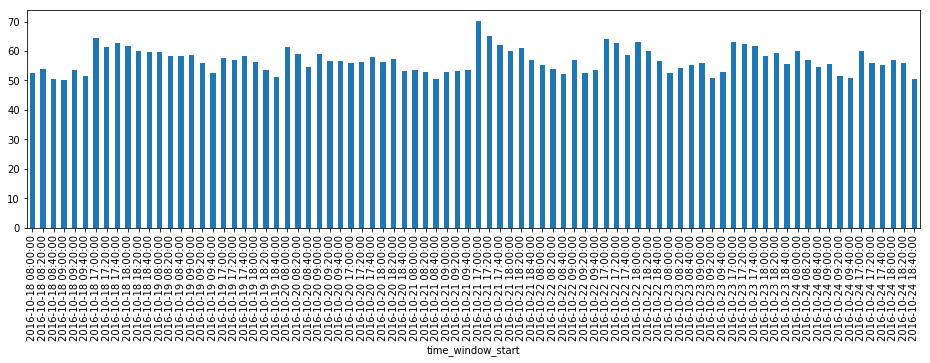

In [178]:
y_test1_pred_ts = Series(y_test1_pred.ravel(), index=travel_time_test1_ts_each_20min.index + 2 * Hour())
y_test1_pred_ts.plot(figsize=(16, 4), kind='bar')
# fig = plt.figure(figsize=(16, 6))
# plt.plot(y_test1_pred.ravel(), 'k')
plt.show()

### 将预测数据写入文件

In [179]:
reload(util)
util.to_csv_task1(path_submission, out_file_name, y_test1_pred_ts, intersection_id, tollgate_id)